# Trabalho Prático 1: Compressão de Imagens

## Alunos: 

- Felipe Eduardo dos Santos
- Renan Antunes Braga Bomtempo

# Introdução

O objetivo deste trabalho é implementar um algoritmo de compressão de imagens utilizando as técnicas vistas em aula.

Nosso algoritmo de compressão consiste em duas fases:

- **Transformação para o domínio de frequência**: Nesta fase nós aplicamos a transformada discreta do cosseno (DCT) em blocos (tamanho padrão é de 8x8) da imagem de entrada. Porém, guardamos apenas parte do bloco (tamanho padrão é de 5x5) no canto superior esquerdo, a fim de descartar alguns dos coeficientes de maior frequência. Por fim, aplicamos uma normalização dos valores para que eles possam ser armazenados em um inteiro de 8 bits (isto serve também como arrendondamento). Vale apontar que este método acaba eliminando algumas das bordas mais 'finas' da imagem, provocando um borramento sutil, porém as vezes perceptível.

    _Obs:_ Caso a imagem de entrada tenha dimensões que não sejam divisíveis pelo tamanho do bloco, o algoritmo adiciona linhas e ou colunas contendo zeros como '_padding_'. No processo final de descompressão, o padding é removido antes de apresentar a imagem reconstruída.

- **Codificação da imagem transformada:** Nesta fase, convertemos a imagem transformada em um array unidimensional. Neste array aplicamos o algoritmo de comprimento de corrida nos zeros da transformada e salvamos em um arquivo. Incluímos também um header que contém algumas informações necessárias para a reconstrução da imagem.

Na descompressão, também duas fases:

- **Decodificar o arquivo salvo**: Lemos o arquivo salvo, separamos a header para obter as informações sobre a imagem original, e decodificamos o comprimento de corrida para obter os coeficientes do DCT reduzido.

- **Aplicar a transformada inversa**: Reconstruímos o DCT completo a partir do reduzido. Por fim, aplicamos a transformada inversa para obter a reconstrução da imagem original (removendo o padding caso tenha sido utilizado).



# Dependências e Funções Auxiliares

In [24]:
%matplotlib inline
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import fftpack
import matplotlib.image as mpimg

def get_2D_dct(input_img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(input_img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# Calcula o rmse
def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calcula o psnr
def calc_psnr(predictions, targets):
    rmsev = calc_rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Retorna o tamanho de um arquivo em bytes
def file_size(file_path):
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return file_info.st_size

# Printa a imagem 'input_img' em tons de cinza com range 'rang'
def print_gimage(input_img, window_name, rang=(0,255)):
    #plt.subplot(121)
    plt.imshow(input_img, cmap = 'gray', clim=rang)
    plt.title(window_name+" - "+str(input_img.shape)), plt.xticks([]), plt.yticks([])
    plt.show()

# Salva um numpy.ndarray, com elementos do tipo numpy.uint8
# em um arquivo, seja .txt ou .bin
def img_to_file(input_img,output_name,separator=""):
    file = open(output_name, "w")
    input_img.tofile(file,sep=separator)
    file.close()

# De um arquivo txt ou bin, lê um numpy.ndarray de dimenções
# shape(tupla)
def file_to_img(input_name,separator=""):
    file = open(input_name,"r")
    input_img = np.fromfile(file,dtype = np.int8,sep=separator)
    #input_img = input_img.reshape(shape)
    file.close()
    return input_img

# Salvar imagem em PNG
def save_png(input_img, name):
    mpimg.imsave(name+".png", input_img, 0, 255, cmap='gray')

# Compressão

## Abrindo a Imagem

_Atribua à variável "input_img_name" o nome da imagem a ser comprimida._

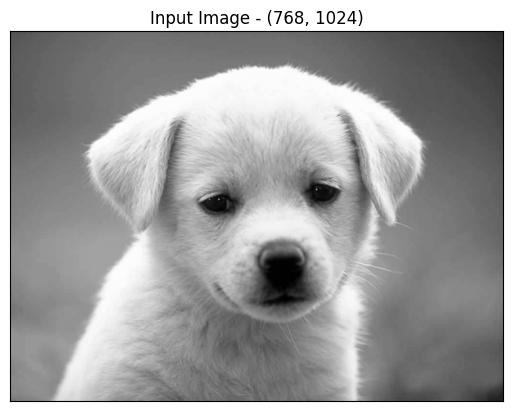

In [25]:
# Nome do arquivo de imagem a ser comprimida
input_img_name = "images/6.pgm"

# Carrega a imagem como um numpy.ndarray, com elementos do tipo numpy.uint8
input_img = cv2.imread(input_img_name,0)

# Mostra imagem que foi carregada
print_gimage(input_img,'Input Image')

## Aplicando a Transfomada

- Aplicamos a DCT em blocos 8x8 da imagem. 
- Dentro de cada bloco, nós armazenamos apenas o sub-bloco 5x5 da esquerda superior, gerando uma imagem menor que a original composta por blocos 5x5.
- Nesta imagem reduzida, aplicamos uma normalização para ao intervalo [-127, 127]

Obs: ambos os valores _step_ e _sv\_step_ podem ser alterados para quaisquer valores, desde que _step_ >= _sv\_step_. Nos testes que fizemos, a configuração _default_ abaixo foi a que apresentou melhores resultados na maioria das casos.

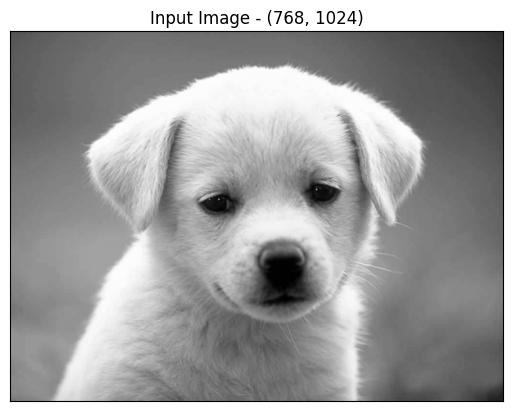

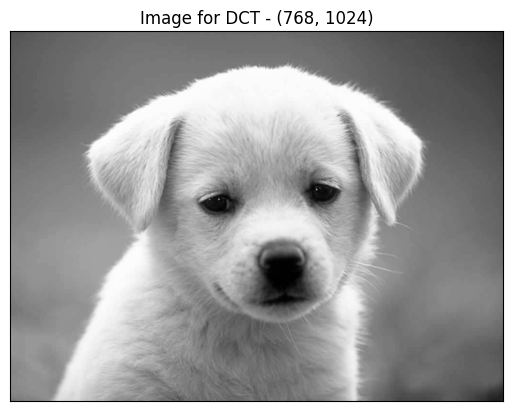

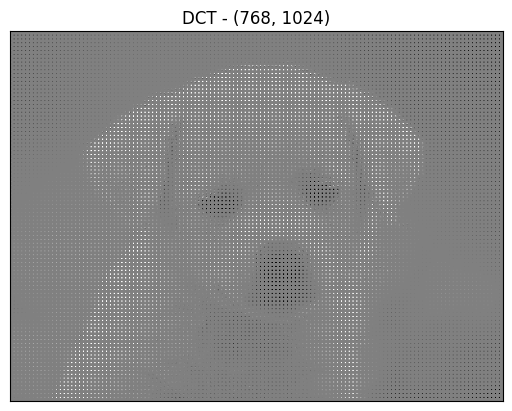

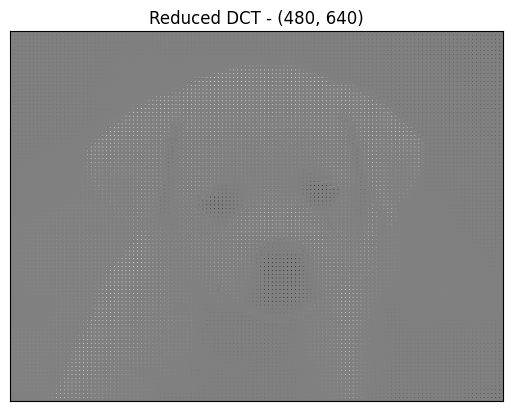

Taxa de compressão da DCT reduzida: 60.938%


In [26]:
# Parâmetros da transformada
step    = 8    # Tamanho do bloco DCT           (default=8)
sv_step = 5    # Tamanho do bloco a ser salvo   (default=5)
dif     = step - sv_step

# Tamanho da imagem original
orig_shape = input_img.shape

# Tamanho da DCT, aplicando padding se necessário
dct_shape = (orig_shape[0]+(step-(orig_shape[0]%step))%step,
             orig_shape[1]+(step-(orig_shape[1]%step))%step)

# Tamanho da DCT reduzida
redu_shape = (dct_shape[0]-(dif*dct_shape[0]//step),
              dct_shape[1]-(dif*dct_shape[1]//step))

# Matriz da DCT completa
DCT = np.zeros(dct_shape, dtype=np.float32)

# Matriz da DCT apenas com os valores relevantes
reduced_dct = np.zeros(redu_shape, dtype=np.float32)

# Imagem em que a DCT será aplicada
dct_img = np.zeros(dct_shape, dtype=np.float32)
dct_img[:orig_shape[0], :orig_shape[1]] = (input_img.astype(float))-128

# Executa a DCT
for y in range(0,dct_shape[0],step):
    for x in range(0,dct_shape[1],step):
        dct_step = get_2D_dct(dct_img[y:y+step, x:x+step])
        # DCT completa
        DCT[y:y+step, x:x+step] = dct_step
        # DCT reduzida
        reduced_dct[y*sv_step//step:y*sv_step//step+sv_step,
                    x*sv_step//step:x*sv_step//step+sv_step] = dct_step[:sv_step,:sv_step]

# Aplica quantização na matriz reduzida da DCT,
# normalizando os valores para o intervalo [-127, 127]
Q = np.max(np.absolute(reduced_dct))/127 #Valor de normalização
reduced_dct = reduced_dct/Q

# Converte o tipo da matriz para inteiros de 8bits para armazenamento
# (serve também como maneira de arrendondar os valores da transormada)
reduced_dct = reduced_dct.astype(np.int8)

# Visualização dos resultados
print_gimage(input_img,"Input Image")
print_gimage(dct_img, "Image for DCT", (-128,127))
print_gimage(DCT,"DCT", (-128,127))
print_gimage(reduced_dct,"Reduced DCT", (-128,127))

# Calcular compressão da DCT reduzida
print("Taxa de compressão da DCT reduzida: {:.3f}%".format((100-(reduced_dct.size/input_img.size)*100)))

## Codificação por Comprimento de Corrida

Implementamos o algoritmo de comprimento de corrida **_apenas para os zeros_**.

Como na maioria dos testes, raramente dois números consecutivos diferentes de zero eram encontrados. Ao aplicar o comprimento de corrida apenas nos zeros, evitamos duplicar o código necessário para armazenar os coeficientes de baixa frequência.

Em contra partida, aplicar o algoritmo nos zeros tende a reduzir bastante o numero de bytes necessários para armazenar a transformada reduzida (como no caso de imagens naturais, onde os coeficientes de alta frequência são zero).

In [27]:
# Transformando a o DCT reduzido em um array unidimencional
dct_arr = np.asarray(reduced_dct).reshape(-1)

# Array codificado
coded_arr = []

# Loop para gerar o array com os comprimentos de corrida dos zeros
i=0
while i < len(dct_arr):
    if (dct_arr[i]!=0):
        coded_arr.append(dct_arr[i])
        i+=1
    else:
        count=1
        while(i+count<len(dct_arr) and count<127 and dct_arr[i+count]==0):
            count+=1
        coded_arr.append(0)
        coded_arr.append(count)
        i+=count

# Mostrar a taxa de compressão do comprimento de corrida aplicado
print("Array original: {} bytes".format(len(dct_arr)))
print("Array codificado: {} bytes".format(len(coded_arr)))
print("Taxa de compressão do comprimento de corrida: {:.3f}%".format(100-len(coded_arr)/len(dct_arr)*100))

Array original: 307200 bytes
Array codificado: 88057 bytes
Taxa de compressão do comprimento de corrida: 71.336%


## Montando o header
Para reconstruir a imagem reduzida na decodificação, precisamos dos seguintes valores:
- **Dimensão original da imagem:** _orig_shape_
- **Valor de quantização:** _Q_
- **Parâmetros da DCT:** _step_ e _sv_step_

In [28]:
# Como os valores da dimensão da imagem podem ser maiores que int8
# separamos as dimenções da imagem como n=qd+r com d = 255
h = orig_shape[0]
hq = h//255
hr = h%255

w = orig_shape[1]
wq = w//255
wr = w%255

# Colocando o header
header = [hq, hr, wq, wr, Q, step, sv_step]
header.extend(coded_arr)
coded_arr = np.array(header, dtype = np.int8)

print("Array com header:   {} bytes".format(len(coded_arr)))

Array com header:   88064 bytes


## Salvando o arquivo e calculando a taxa de compressão total
Ao final da codificação, temos um array unidimensional contendo a transformada reduzida codificada.

Salvamos o array obtido em um arquivo 'coded\_image.bin' e comparamos o tamanho com a imagem original (_não com o arquivo original_).

In [29]:
# Salva a imagem original e o array codificado em arquivos '.out'
img_to_file(input_img,"original_image.out")
img_to_file(coded_arr,"coded_image.out")

# Calculando a taxa de compressão
compression_rate = 1-(file_size("coded_image.out")/file_size("original_image.out"))
print("Taxa de compressão total: {:.3f}%".format(compression_rate * 100))

Taxa de compressão total: 88.802%


# Descompressão

## Abrindo a imagem comprimida e extraindo o Header

_Atribua a variável "compressed_img_name" o nome da imagem a ser descomprimida._

Abrimos a imagem comprimida e extraímos as informações armazenadas no header.

In [30]:
# Nome do arquivo contendo a imagem comprimida
coded_img_name = "coded_image.out"

# Arquivo comprimido é salvo em um array
coded_arr = file_to_img(coded_img_name)

# Separando o header da imagem codificada
header = coded_arr[:7]
coded_arr = coded_arr[7:]

# Dimensão da imagem original armazenado no header
orig_shape = (np.uint8(header[0])*255 + np.uint8(header[1]),
              np.uint8(header[2])*255 + np.uint8(header[3]))

# Valor de quantização
Q = header[4]

# Parâmetros da DCT
step    = header[5]
sv_step = header[6]
dif = step - sv_step

# Informações do header
print("---Dados recuperados do Header---\n")
print("Dimensão da imagem original:\n orig_shape = {}\n".format(orig_shape))
print("Valor de quantização:\n Q = {}\n".format(Q))
print("Parâmetros da DCT:\n step = {0}\n sv_step = {1}".format(step, sv_step))

---Dados recuperados do Header---

Dimensão da imagem original:
 orig_shape = (768, 1024)

Valor de quantização:
 Q = 7

Parâmetros da DCT:
 step = 8
 sv_step = 5


## Decodificação

Realizamos o processo de decodificação, obtendo o array da imagem transformada reduzida.

In [31]:
# Array decodificado
decoded_arr = []

# Decodifica o arquivo de bytes gerado pela compressão
i=0
while i < len(coded_arr):
    if coded_arr[i] != 0:
        decoded_arr.append(coded_arr[i])
        if (i == len(coded_arr)-2):
            decoded_arr.append(coded_arr[i+1])
    else:
        for j in range(coded_arr[i+1]):
            decoded_arr.append(0)
        i+=1
    i+=1
decoded_arr = np.array(decoded_arr,dtype = np.int8)

print("Array decodificado: {} bytes".format(len(decoded_arr)))

Array decodificado: 307200 bytes


## Transformada Inversa

Com o array unidimensional decodificado, podemos redimensioná-lo para obter a matriz da DCT reduzida. Com ela, restauramos a DCT original e aplicamos a transformada inversa.

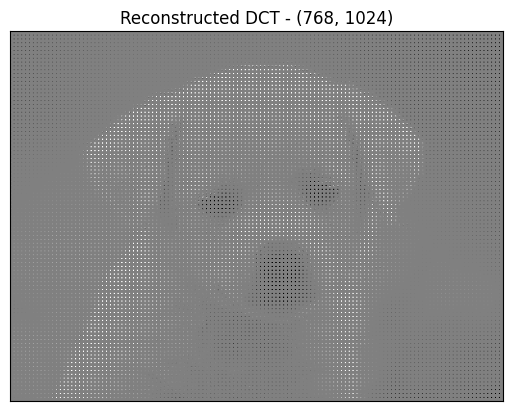

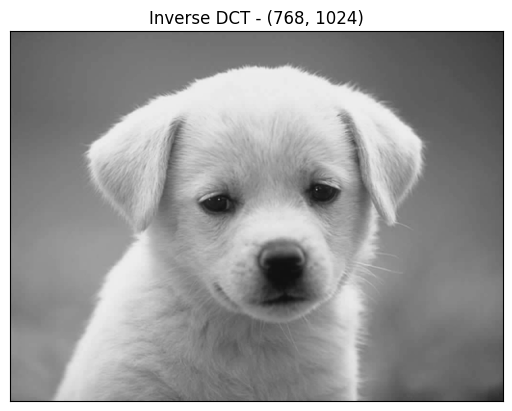

In [32]:
# Dimensão da DCT, aplicando padding se necessário
dct_shape = (orig_shape[0]+(step-(orig_shape[0]%step))%step,
             orig_shape[1]+(step-(orig_shape[1]%step))%step)

# Dimensão da DCT reduzida
redu_shape = (dct_shape[0]-(dif*dct_shape[0]//step),
              dct_shape[1]-(dif*dct_shape[1]//step))

# DCT reduzida obtida na decodificação
reduced_dct = decoded_arr.reshape(redu_shape)

# Matriz da DCT completa
DCT = np.zeros(dct_shape, dtype=np.float32)

# Extendendo a DCT reduzida para a dimensão original da DCT
for y in range(0,redu_shape[0],sv_step):
    for x in range(0,redu_shape[1],sv_step):
        block = np.zeros((step,step),dtype=np.float32)
        block[:sv_step, :sv_step] = reduced_dct[y:y+sv_step, x:x+sv_step]
        DCT[y+(dif*y//sv_step):y+(dif*y//sv_step)+step,
            x+(dif*x//sv_step):x+(dif*x//sv_step)+step] = block

# Reverte a quantização
DCT = Q*DCT

# Matriz da DCT inversa
inverse_dct  = np.zeros(dct_shape, dtype=np.float32)

# Transformada inversa
for y in range(0,dct_shape[0],step):
    for x in range(0,dct_shape[1],step):
        block = get_2d_idct(DCT[y:y+step, x:x+step])
        inverse_dct[y:y+step, x:x+step] = block

# Mostra as imagens obtidas
print_gimage(DCT,          "Reconstructed DCT", (-128,127))
print_gimage(inverse_dct,  "Inverse DCT", (-128,127))

# Reconstrução e análise

Abaixo mostramos o PSNR obtido com a reconstrução. De maneira opcional, salvamos as imagens, original e reconstruida, em '.png' a fim de realizar uma comparação visual dos resultados obtidos.

PSNR = 31.894
Taxa de compressão = 88.802%


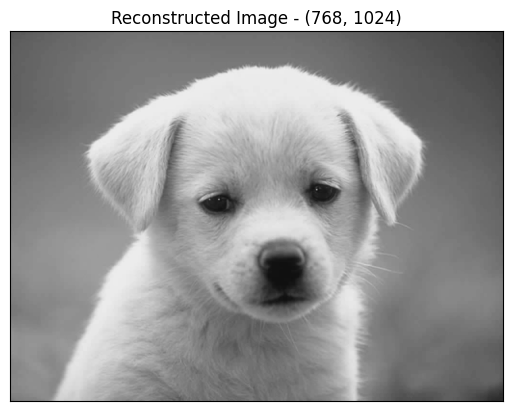

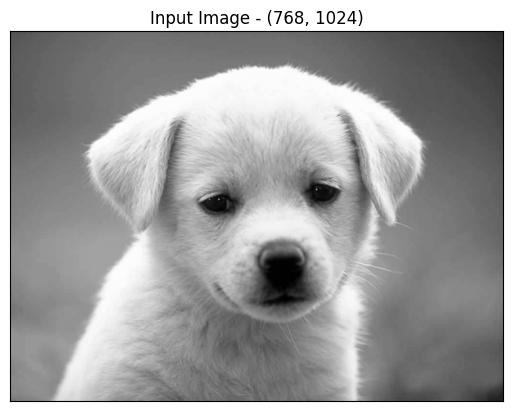

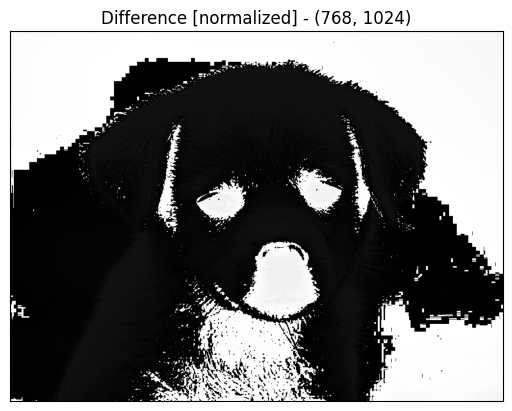

In [33]:
# Imagem reconstruida
reco_img = np.uint8(inverse_dct[:orig_shape[0], :orig_shape[1]]+128)

# Calcular PSNR
psnr = calc_psnr(np.uint8(input_img), reco_img)

# Mostrar valores obtidos nas métricas
print("PSNR = {:.3f}".format(psnr))
print("Taxa de compressão = {:.3f}%".format(compression_rate*100))

# Mostrar imagem de entrada / imagem reconstruida / diferença entre as imagens
print_gimage(reco_img, "Reconstructed Image")
print_gimage(input_img, "Input Image")
img_dif = abs(input_img-reco_img)
print_gimage(img_dif, "Difference [normalized]", (np.min(img_dif),np.max(img_dif)))

# Salvar imagens em .png para comparação visual
salvar_png = False

if (salvar_png):
    save_png(input_img, "{0}".format(input_img_name.split('.')[0]))
    save_png(reco_img, "{0}-{1}_{2}_[{3:.2f}]_[{4:.2f}]".format(input_img_name.split('.')[0], step, sv_step, compression_rate*100, psnr))